In [54]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import matplotlib.pyplot as plt
import matplotlib as mpl

FONTSIZE = 16
plt.rcParams.update({'font.size': FONTSIZE})

def get_common_configs():
    color_scheme = {128: "#1f77b4", 1024: "#2ca02c", 8192: "#ff7f0e", 64: "#1f77b4", 288: "#ff7f0e"}
    marker_scheme = {128: "o", 1024: "v", 8192: "s", 64: "o", 288: "s"}
    linestyle_scheme = {"Vanilla NN": "-", "GNN": ":", "Data-Driven NN": "-"}
    return color_scheme, marker_scheme, linestyle_scheme

def make_legends(linestyle_scheme, color_scheme, marker_scheme):
    arch_lines = [plt.Line2D([0], [0], color='gray', linestyle=linestyle_scheme[arch], label=arch) 
                  for arch in linestyle_scheme.keys()]
    sample_patches = [plt.Line2D([0], [0], color=color_scheme[size], marker=marker_scheme[size], 
                                linestyle='none', label=f'{size}', markersize=8)
                     for size in color_scheme.keys()]
    return arch_lines, sample_patches

def setup_results_interpreter():
    results_interpretor = rri.RayResultsinterpreter()
    def custom_data_filler(out_row, reference_row): out_row['path'] = reference_row['path']
    def default_condition_setter(condition_name): return None
    return results_interpretor, custom_data_filler, default_condition_setter

# --- Data Parse Functions ---

def parse_serial_system():
    testset_name = "finals_serial"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Vanilla NN": lambda config: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_serial',
        "echelon_stock_hard": lambda config: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/echelon_stock_hard',
        "GNN": lambda config: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
    }
    configs = ["serial_system_3", "serial_system_4", "serial_system_5", "serial_system_6", "serial_system_7"]
    sample_sizes = [128, 1024, 8192]
    dfs = []
    for arch_name, path_fn in architectures.items():
        for config in configs:
            path = path_fn(config)
            system_length = int(config.split('_')[-1])
            for sample_size in sample_sizes:
                df = results_interpretor.make_table({1: path},
                    {'train_dev_sample_and_batch_size': [sample_size],
                     'store_underage_cost': [9],
                     'store_lead_time': [4],
                     'samples': [1],
                     'config': [config]},
                    default_condition_setter, custom_data_filler,
                    sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
                if df.empty: continue
                df.insert(2, 'Architecture Class', arch_name)
                df.insert(1, 'hyperparam_name', arch_name)
                df['train_dev_sample_and_batch_size'] = sample_size
                df['config'] = config
                df['system_length'] = system_length
                dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    optimal_losses = {}
    for config in configs:
        system_length = int(config.split('_')[-1])
        optimal_data = df[(df['Architecture Class'] == 'echelon_stock_hard') & 
                          (df['train_dev_sample_and_batch_size'] == 8192) & 
                          (df['config'] == config)]
        if not optimal_data.empty:
            optimal_losses[system_length] = optimal_data['Test Loss'].min()
    stats_by_arch_sample_and_system_length = {}
    for system_length, optimal_loss in optimal_losses.items():
        system_data = df[df['system_length'] == system_length].copy()
        system_data = system_data[system_data['Architecture Class'] != 'echelon_stock_hard']
        if system_data.empty: continue
        system_data.loc[:, 'Gap %'] = ((system_data['Test Loss'] - optimal_loss) / optimal_loss) * 100
        for arch in system_data['Architecture Class'].unique():
            for sample_size in sample_sizes:
                key = (arch, sample_size)
                if key not in stats_by_arch_sample_and_system_length:
                    stats_by_arch_sample_and_system_length[key] = []
                sample_data = system_data[(system_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                       (system_data['Architecture Class'] == arch)]
                if not sample_data.empty:
                    gaps = sample_data['Gap %'].to_numpy()
                    mean_gap = np.mean(gaps)
                    stats_by_arch_sample_and_system_length[key].append({
                        'system_length': system_length,
                        'mean_gap': mean_gap
                    })
    return {
        "stats": stats_by_arch_sample_and_system_length,
        "linestyle_scheme": linestyle_scheme,
        "color_scheme": color_scheme,
        "marker_scheme": marker_scheme
    }

def parse_one_warehouse():
    testset_name = "finals_one_warehouse_n_stores"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Vanilla NN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_one_warehouse',
        "GNN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
    }
    n_stores = [3, 5, 10, 20, 30, 50]
    sample_sizes = [128, 1024, 8192]
    dfs = []
    for arch_name, path_fn in architectures.items():
        for n_store in n_stores:
            path = path_fn(n_store)
            for sample_size in sample_sizes:
                df = results_interpretor.make_table({1: path},
                    {'train_dev_sample_and_batch_size': [sample_size],
                     'store_underage_cost': [9],
                     'store_lead_time': [[2, 6]],
                     'samples': [1],
                     'n_stores': [n_store]},
                    default_condition_setter, custom_data_filler,
                    sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=100)
                if df.empty: continue
                df.insert(2, 'Architecture Class', arch_name)
                df.insert(1, 'hyperparam_name', arch_name)
                df['train_dev_sample_and_batch_size'] = sample_size
                df['n_stores'] = n_store
                dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    stats_by_arch_sample_and_stores = {}
    for n_store in n_stores:
        store_data = df[df['n_stores'] == n_store].copy()
        if store_data.empty: continue
        best_test_loss = store_data['Test Loss'].min()
        store_data.loc[:, 'Gap %'] = ((store_data['Test Loss'] - best_test_loss) / best_test_loss) * 100
        for arch in store_data['Architecture Class'].unique():
            for sample_size in sample_sizes:
                key = (arch, sample_size)
                if key not in stats_by_arch_sample_and_stores:
                    stats_by_arch_sample_and_stores[key] = []
                sample_data = store_data[(store_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                       (store_data['Architecture Class'] == arch)]
                if not sample_data.empty:
                    gaps = sample_data['Gap %'].to_numpy()
                    mean_gap = np.mean(gaps)
                    stats_by_arch_sample_and_stores[key].append({
                        'n_stores': n_store,
                        'mean_gap': mean_gap
                    })
    return {
        "stats": stats_by_arch_sample_and_stores,
        "linestyle_scheme": linestyle_scheme,
        "color_scheme": color_scheme,
        "marker_scheme": marker_scheme
    }

def parse_transshipment():
    testset_name = "finals_transshipment"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "GNN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_transshipment',
        "Vanilla NN": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_transshipment',
    }
    n_stores = [3, 5, 10, 20, 30, 50]
    sample_sizes = [128, 1024, 8192]
    lower_bounds = {
        3: 8.533673716946652,
        5: 7.902133198919353,
        10: 8.296968310182638,
        20: 8.731082080524004,
        30: 8.37732777290095,
        50: 8.118102268777966,
    }
    dfs = []
    for arch_name, path_fn in architectures.items():
        for n_store in n_stores:
            path = path_fn(n_store)
            for sample_size in sample_sizes:
                df = results_interpretor.make_table({1: path},
                    {'train_dev_sample_and_batch_size': [sample_size],
                     'store_underage_cost': [9],
                     'store_lead_time': [4],
                     'samples': [1],
                     'n_stores': [n_store]},
                    default_condition_setter, custom_data_filler,
                    sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=100)
                if df.empty: continue
                df.insert(2, 'Architecture Class', arch_name)
                df.insert(1, 'hyperparam_name', arch_name)
                df['train_dev_sample_and_batch_size'] = sample_size
                df['n_stores'] = n_store
                dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    stats_by_arch_sample_and_stores = {}
    for n_store in n_stores:
        store_data = df[df['n_stores'] == n_store].copy()
        if store_data.empty: continue
        lower_bound = lower_bounds[n_store]
        store_data.loc[:, 'Optimality Gap %'] = ((store_data['Test Loss'] - lower_bound) / lower_bound) * 100
        for arch in store_data['Architecture Class'].unique():
            for sample_size in sample_sizes:
                key = (arch, sample_size)
                if key not in stats_by_arch_sample_and_stores:
                    stats_by_arch_sample_and_stores[key] = []
                sample_data = store_data[(store_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                       (store_data['Architecture Class'] == arch)]
                if not sample_data.empty:
                    gaps = sample_data['Optimality Gap %'].to_numpy()
                    mean_gap = np.mean(gaps)
                    stats_by_arch_sample_and_stores[key].append({
                        'n_stores': n_store,
                        'mean_gap': mean_gap
                    })
    return {
        "stats": stats_by_arch_sample_and_stores,
        "linestyle_scheme": linestyle_scheme,
        "color_scheme": color_scheme,
        "marker_scheme": marker_scheme
    }

def parse_real_one_warehouse():
    testset_name = "finals_real_one_warehouse_n_stores"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Data-Driven NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/data_driven_net_real',
        "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_selfloop',
        "Just-In-Time": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/just_in_time_real',
    }
    store_counts = [3, 5, 10, 15, 21]
    sample_sizes = [64, 288]
    dfs = []
    jit_dfs = []
    for arch_name, path in architectures.items():
        for n_stores in store_counts:
            if arch_name == "Just-In-Time":
                for sample_size in sample_sizes:
                    jit_df = results_interpretor.make_table({1: path},
                        {'n_stores': [n_stores], 'train_dev_sample_and_batch_size': [sample_size]},
                        default_condition_setter, custom_data_filler,
                        sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
                    if not jit_df.empty:
                        jit_df.insert(2, 'Architecture Class', arch_name)
                        jit_df.insert(1, 'hyperparam_name', arch_name)
                        jit_df['n_stores'] = n_stores
                        jit_df['train_dev_sample_and_batch_size'] = sample_size
                        jit_dfs.append(jit_df)
            else:
                for sample_size in sample_sizes:
                    df = results_interpretor.make_table({1: path},
                        {'train_dev_sample_and_batch_size': [sample_size],
                         'n_stores': [n_stores],
                         'test_n_samples': [sample_size]},
                        default_condition_setter, custom_data_filler,
                        sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
                    if df.empty: continue
                    df.insert(2, 'Architecture Class', arch_name)
                    df.insert(1, 'hyperparam_name', arch_name)
                    df['train_dev_sample_and_batch_size'] = sample_size
                    df['n_stores'] = n_stores
                    dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    jit_df = pd.concat(jit_dfs, ignore_index=True) if jit_dfs else pd.DataFrame()
    jit_losses = {}
    for n_stores in store_counts:
        for sample_size in sample_sizes:
            jit_data = jit_df[(jit_df['n_stores'] == n_stores) & 
                              (jit_df['train_dev_sample_and_batch_size'] == sample_size)]
            if not jit_data.empty:
                jit_loss = jit_data['Test Loss'].min()
                jit_losses[(n_stores, sample_size)] = jit_loss
    stats_by_arch_sample_and_stores = {}
    for n_stores in store_counts:
        stores_data = df[df['n_stores'] == n_stores].copy()
        if stores_data.empty: continue
        for sample_size in sample_sizes:
            if (n_stores, sample_size) not in jit_losses: continue
            jit_loss = jit_losses[(n_stores, sample_size)]
            sample_data = stores_data[stores_data['train_dev_sample_and_batch_size'] == sample_size].copy()
            if sample_data.empty: continue
            sample_data.loc[:, 'Loss Ratio'] = sample_data['Test Loss'] / jit_loss
            for arch in sample_data['Architecture Class'].unique():
                key = (arch, sample_size)
                if key not in stats_by_arch_sample_and_stores:
                    stats_by_arch_sample_and_stores[key] = []
                arch_data = sample_data[sample_data['Architecture Class'] == arch]
                if not arch_data.empty:
                    ratios = arch_data['Loss Ratio'].to_numpy()
                    mean_percentage = np.mean(ratios * 100)
                    stats_by_arch_sample_and_stores[key].append({
                        'n_stores': n_stores,
                        'mean_percentage': mean_percentage
                    })
    return {
        "stats": stats_by_arch_sample_and_stores,
        "linestyle_scheme": linestyle_scheme,
        "color_scheme": color_scheme,
        "marker_scheme": marker_scheme,
        "store_counts": store_counts
    }

def parse_many_warehouses():
    testset_name = "finals_n_warehouses_n_stores"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Vanilla NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_n_warehouses',
        "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_selfloop',
    }
    configs = [
        "n_warehouse_10_2_lost_demand",
        "n_warehouse_20_3_lost_demand",
        "n_warehouse_30_4_lost_demand", 
        "n_warehouse_40_5_lost_demand", 
        "n_warehouse_50_6_lost_demand"
    ]
    config_to_stores_warehouses = {
        "n_warehouse_10_2_lost_demand": (10, 2),
        "n_warehouse_20_3_lost_demand": (20, 3),
        "n_warehouse_30_4_lost_demand": (30, 4),
        "n_warehouse_40_5_lost_demand": (40, 5),
        "n_warehouse_50_6_lost_demand": (50, 6)
    }
    sample_sizes = [128, 1024, 8192]
    dfs = []
    for arch_name, path in architectures.items():
        for config in configs:
            for sample_size in sample_sizes:
                df = results_interpretor.make_table({1: path},
                    {'train_dev_sample_and_batch_size': [sample_size],
                     'store_underage_cost': [9],
                     'config': [config],
                     'samples': [1]},
                    default_condition_setter, custom_data_filler,
                    sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
                if df.empty: continue
                df.insert(2, 'Architecture Class', arch_name)
                df.insert(1, 'hyperparam_name', arch_name)
                df['train_dev_sample_and_batch_size'] = sample_size
                df['config'] = config
                df['n_stores'] = config_to_stores_warehouses[config][0]
                df['n_warehouses'] = config_to_stores_warehouses[config][1]
                dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    best_losses = {}
    for config in configs:
        config_data = df[df['config'] == config]
        if not config_data.empty:
            best_losses[config] = config_data['Test Loss'].min()
    stats_by_arch_sample_and_config = {}
    for config in configs:
        if config not in best_losses: continue
        best_loss = best_losses[config]
        config_data = df[df['config'] == config].copy()
        if config_data.empty: continue
        config_data.loc[:, 'Gap %'] = ((config_data['Test Loss'] - best_loss) / best_loss) * 100
        for arch in config_data['Architecture Class'].unique():
            for sample_size in sample_sizes:
                key = (arch, sample_size)
                if key not in stats_by_arch_sample_and_config:
                    stats_by_arch_sample_and_config[key] = []
                sample_data = config_data[(config_data['train_dev_sample_and_batch_size'] == sample_size) & 
                                       (config_data['Architecture Class'] == arch)]
                if not sample_data.empty:
                    gaps = sample_data['Gap %'].to_numpy()
                    mean_gap = np.mean(gaps)
                    stats_by_arch_sample_and_config[key].append({
                        'config': config,
                        'n_stores': config_to_stores_warehouses[config][0],
                        'n_warehouses': config_to_stores_warehouses[config][1],
                        'mean_gap': mean_gap
                    })
    x_ticks = [10, 20, 30, 40, 50]
    x_tick_labels = []
    for n_stores in x_ticks:
        for config, (stores, warehouses) in config_to_stores_warehouses.items():
            if stores == n_stores:
                x_tick_labels.append(f"({stores},{warehouses})")
                break
    return {
        "stats": stats_by_arch_sample_and_config,
        "linestyle_scheme": linestyle_scheme,
        "color_scheme": color_scheme,
        "marker_scheme": marker_scheme,
        "x_ticks": x_ticks,
        "x_tick_labels": x_tick_labels
    }

def parse_real_many_warehouses():
    testset_name = "finals_real_n_warehouses_n_stores"
    results_interpretor, custom_data_filler, default_condition_setter = setup_results_interpreter()
    color_scheme, marker_scheme, linestyle_scheme = get_common_configs()
    architectures = {
        "Data-Driven NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/data_driven_net_n_warehouses_real',
        "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_real_selfloop',
        "Just-In-Time": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/just_in_time_real',
    }
    configs = [
        "n_warehouse_21_2_real_lost_demand",
        "n_warehouse_21_3_real_lost_demand",
        "n_warehouse_21_4_real_lost_demand",
        "n_warehouse_21_5_real_lost_demand"
    ]
    config_to_warehouses = {
        "n_warehouse_21_2_real_lost_demand": 2,
        "n_warehouse_21_3_real_lost_demand": 3,
        "n_warehouse_21_4_real_lost_demand": 4,
        "n_warehouse_21_5_real_lost_demand": 5
    }
    sample_sizes = [64, 288]
    dfs = []
    jit_dfs = []
    for arch_name, path in architectures.items():
        for config in configs:
            if arch_name == "Just-In-Time":
                for sample_size in sample_sizes:
                    jit_df = results_interpretor.make_table({1: path},
                        {'config': [config], 'train_dev_sample_and_batch_size': [sample_size]},
                        default_condition_setter, custom_data_filler,
                        sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
                    if not jit_df.empty:
                        jit_df.insert(2, 'Architecture Class', arch_name)
                        jit_df.insert(1, 'hyperparam_name', arch_name)
                        jit_df['config'] = config
                        jit_df['n_warehouses'] = config_to_warehouses[config]
                        jit_df['train_dev_sample_and_batch_size'] = sample_size
                        jit_dfs.append(jit_df)
            else:
                for sample_size in sample_sizes:
                    df = results_interpretor.make_table({1: path},
                        {'train_dev_sample_and_batch_size': [sample_size],
                        'config': [config],
                        'test_n_samples': [sample_size]},
                        default_condition_setter, custom_data_filler,
                        sort_by='dev_loss', pick_row_from_run_by='dev_loss', test_loss_limit=25)
                    if df.empty: continue
                    df.insert(2, 'Architecture Class', arch_name)
                    df.insert(1, 'hyperparam_name', arch_name)
                    df['train_dev_sample_and_batch_size'] = sample_size
                    df['config'] = config
                    df['n_warehouses'] = config_to_warehouses[config]
                    dfs.append(df)
    if not dfs:
        return None
    df = pd.concat(dfs, ignore_index=True)
    jit_df = pd.concat(jit_dfs, ignore_index=True) if jit_dfs else pd.DataFrame()
    jit_losses = {}
    for config in configs:
        for sample_size in sample_sizes:
            jit_data = jit_df[(jit_df['config'] == config) & 
                              (jit_df['train_dev_sample_and_batch_size'] == sample_size)]
            if not jit_data.empty:
                jit_loss = jit_data['Test Loss'].min()
                jit_losses[(config, sample_size)] = jit_loss
    stats_by_arch_sample_and_config = {}
    for config in configs:
        config_data = df[df['config'] == config].copy()
        if config_data.empty: continue
        for sample_size in sample_sizes:
            if (config, sample_size) not in jit_losses: continue
            jit_loss = jit_losses[(config, sample_size)]
            sample_data = config_data[config_data['train_dev_sample_and_batch_size'] == sample_size].copy()
            if sample_data.empty: continue
            sample_data.loc[:, 'Loss Ratio'] = sample_data['Test Loss'] / jit_loss
            for arch in sample_data['Architecture Class'].unique():
                key = (arch, sample_size)
                if key not in stats_by_arch_sample_and_config:
                    stats_by_arch_sample_and_config[key] = []
                arch_data = sample_data[sample_data['Architecture Class'] == arch]
                if not arch_data.empty:
                    ratios = arch_data['Loss Ratio'].to_numpy()
                    mean_percentage = np.mean(ratios * 100)
                    std_percentage = np.std(ratios * 100)
                    ci_95 = 1.96 * std_percentage / np.sqrt(len(ratios))
                    stats_by_arch_sample_and_config[key].append({
                        'config': config,
                        'n_warehouses': config_to_warehouses[config],
                        'mean_percentage': mean_percentage,
                        'ci_lower': mean_percentage - ci_95,
                        'ci_upper': mean_percentage + ci_95
                    })
    x_ticks = sorted(list(config_to_warehouses.values()))
    return {
        "stats": stats_by_arch_sample_and_config,
        "linestyle_scheme": linestyle_scheme,
        "color_scheme": color_scheme,
        "marker_scheme": marker_scheme,
        "x_ticks": x_ticks
    }
# --- Data Loading ---
serial_system_data = parse_serial_system()
one_warehouse_data = parse_one_warehouse()
real_one_warehouse_data = parse_real_one_warehouse()
transshipment_data = parse_transshipment()
many_warehouses_data = parse_many_warehouses()
real_many_warehouses_data = parse_real_many_warehouses()

Error processing files in /user/ml4723/Prj/NIC/ray_results/finals_transshipment/GNN_transshipment/run_2025-05-19_10-30-20/run_cabbe_00027_27_config=transshipment_backlogged,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0.0100,_2025-05-19_10-30-22: Expecting value: line 1 column 1 (char 0)


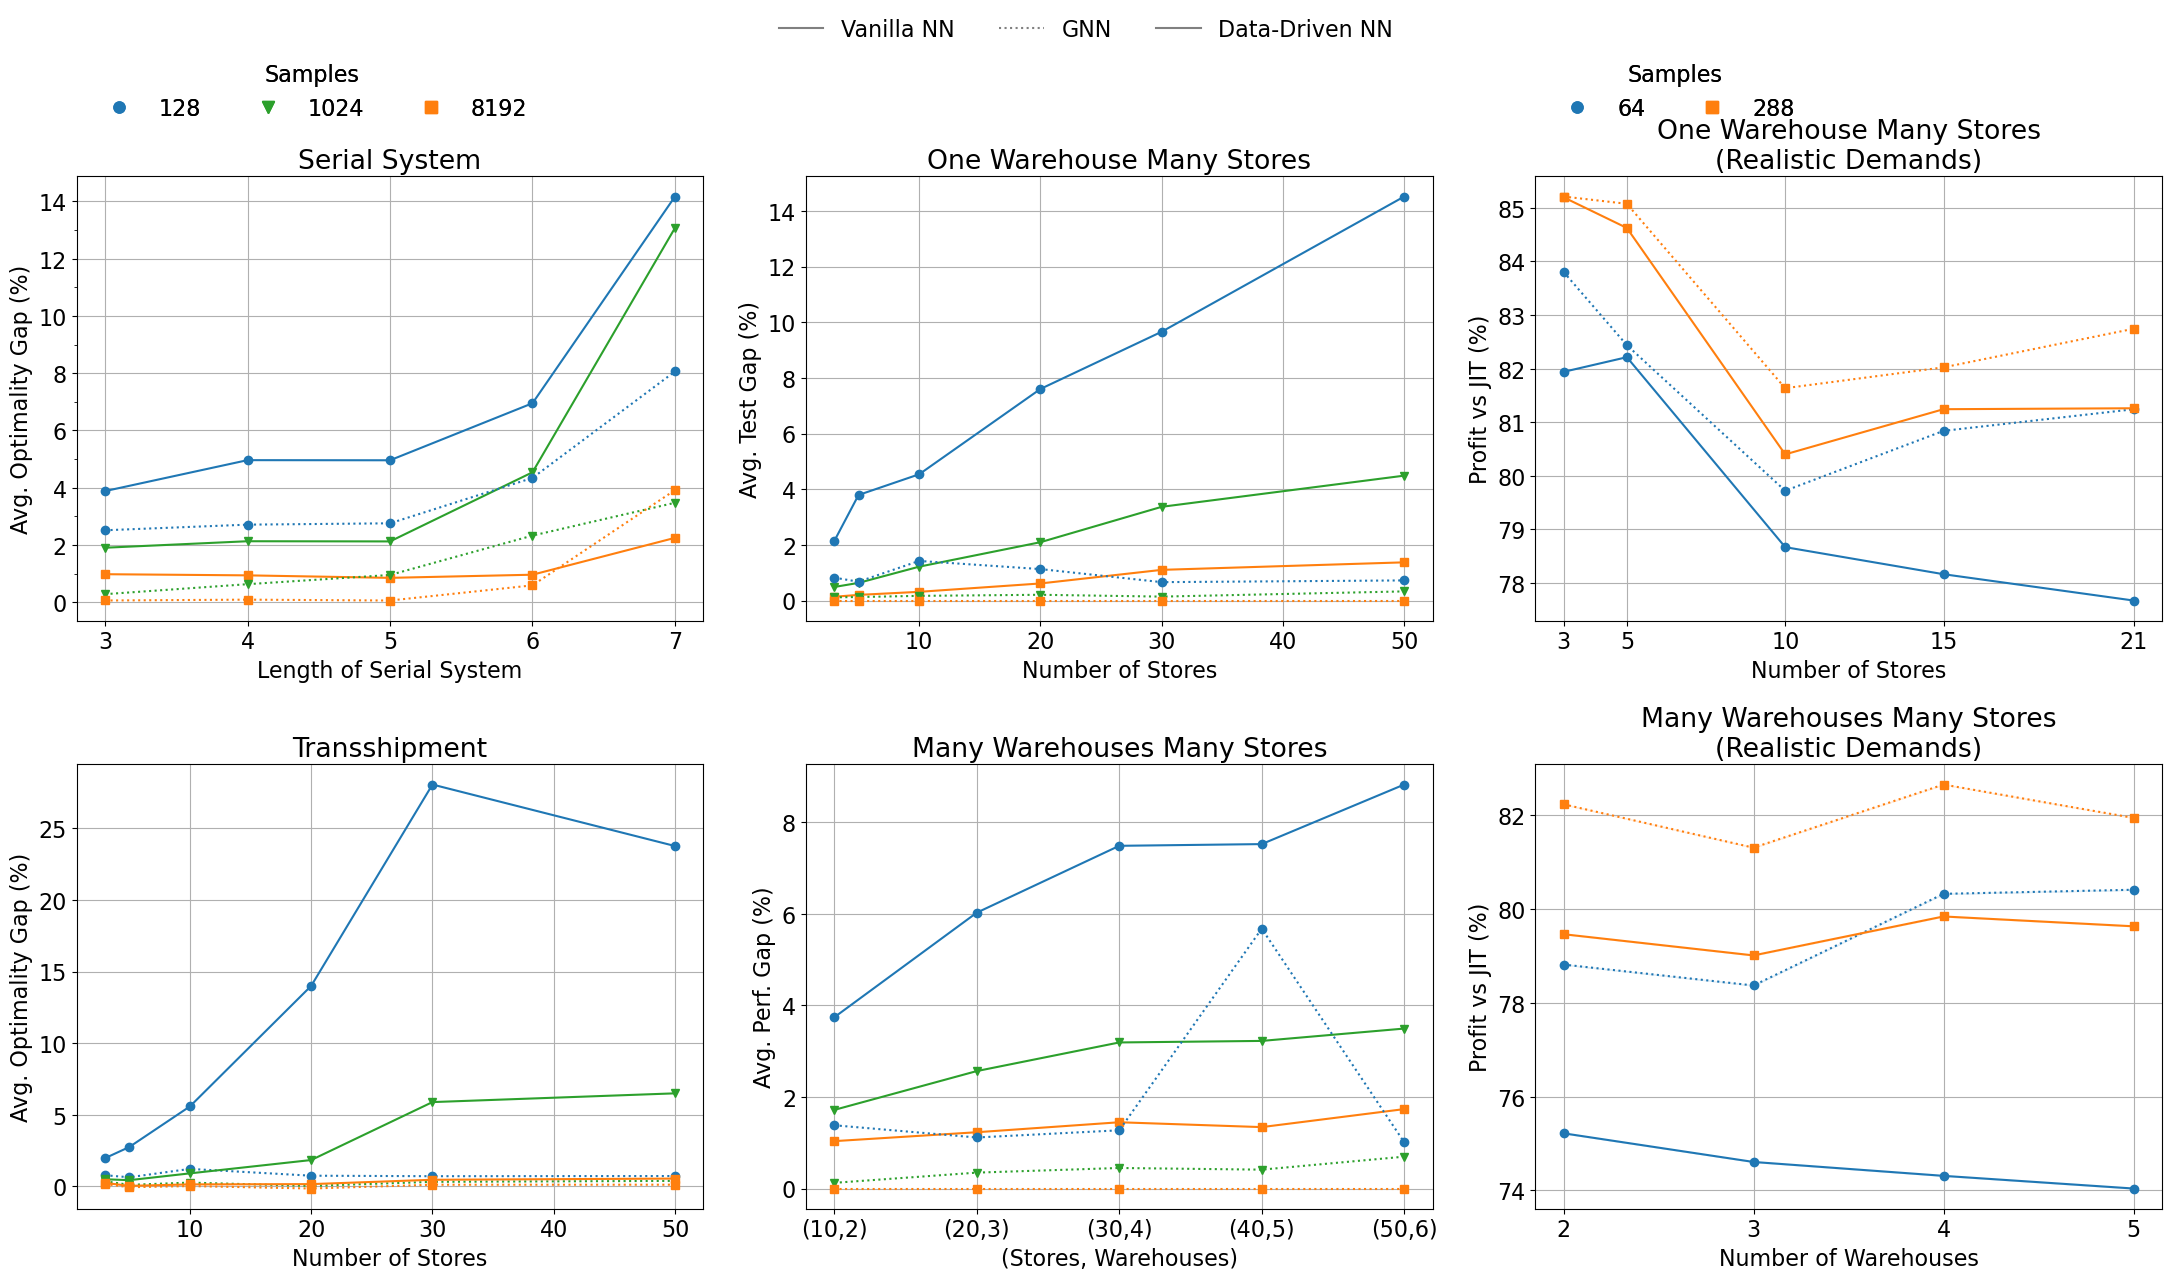

In [60]:

# --- Plot Functions ---

def plot_serial_system(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    for (arch, sample_size), stats_list in stats.items():
        stats_df = pd.DataFrame(stats_list)
        if not stats_df.empty:
            system_length_array = stats_df['system_length'].to_numpy()
            mean_gap_array = stats_df['mean_gap'].to_numpy()
            ax.plot(system_length_array, mean_gap_array,
                    marker=marker_scheme[sample_size],
                    color=color_scheme[sample_size],
                    linestyle=linestyle_scheme.get(arch, "-"),
                    markersize=6)
    ax.set_xlabel('Length of Serial System')
    ax.set_ylabel('Avg. Optimality Gap (%)')
    ax.set_title('Serial System')
    ax.grid(True)
    ax.set_xticks(range(3, 8))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    return linestyle_scheme, color_scheme, marker_scheme

def plot_one_warehouse(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    for (arch, sample_size), stats_list in stats.items():
        stats_df = pd.DataFrame(stats_list)
        if not stats_df.empty:
            n_stores_array = stats_df['n_stores'].to_numpy()
            mean_gap_array = stats_df['mean_gap'].to_numpy()
            ax.plot(n_stores_array, mean_gap_array,
                    marker=marker_scheme[sample_size],
                    color=color_scheme[sample_size],
                    linestyle=linestyle_scheme.get(arch, "-"),
                    markersize=6)
    ax.set_xlabel('Number of Stores')
    ax.set_ylabel('Avg. Test Gap (%)')
    ax.set_title('One Warehouse Many Stores')
    ax.grid(True)
    return linestyle_scheme, color_scheme, marker_scheme

def plot_transshipment(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    for (arch, sample_size), stats_list in stats.items():
        stats_df = pd.DataFrame(stats_list)
        if not stats_df.empty:
            n_stores_array = stats_df['n_stores'].to_numpy()
            mean_gap_array = stats_df['mean_gap'].to_numpy()
            ax.plot(n_stores_array, mean_gap_array,
                    marker=marker_scheme[sample_size],
                    color=color_scheme[sample_size],
                    linestyle=linestyle_scheme.get(arch, "-"),
                    markersize=6)
    ax.set_xlabel('Number of Stores')
    ax.set_ylabel('Avg. Optimality Gap (%)')
    ax.set_title('Transshipment')
    ax.grid(True)
    return linestyle_scheme, color_scheme, marker_scheme

def plot_real_one_warehouse(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    store_counts = data["store_counts"]
    for (arch, sample_size), stats_list in stats.items():
        stats_df = pd.DataFrame(stats_list)
        if not stats_df.empty:
            stats_df = stats_df.sort_values('n_stores')
            n_stores_array = stats_df['n_stores'].to_numpy()
            mean_percentage_array = stats_df['mean_percentage'].to_numpy()
            ax.plot(n_stores_array, mean_percentage_array,
                    marker=marker_scheme[sample_size],
                    color=color_scheme[sample_size],
                    linestyle=linestyle_scheme.get(arch, "-"),
                    markersize=6)
    ax.set_xlabel('Number of Stores')
    ax.set_ylabel('Profit vs JIT (%)')
    ax.set_title('One Warehouse Many Stores\n(Realistic Demands)')
    ax.grid(True)
    ax.set_xticks(store_counts)
    return linestyle_scheme, color_scheme, marker_scheme

def plot_many_warehouses(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    x_ticks = data["x_ticks"]
    x_tick_labels = data["x_tick_labels"]
    for (arch, sample_size), stats_list in stats.items():
        stats_df = pd.DataFrame(stats_list)
        if not stats_df.empty:
            stats_df = stats_df.sort_values('n_stores')
            n_stores_array = stats_df['n_stores'].to_numpy()
            mean_gap_array = stats_df['mean_gap'].to_numpy()
            ax.plot(n_stores_array, mean_gap_array,
                    marker=marker_scheme[sample_size],
                    color=color_scheme[sample_size],
                    linestyle=linestyle_scheme.get(arch, "-"),
                    markersize=6)
    ax.set_xlabel('(Stores, Warehouses)')
    ax.set_ylabel('Avg. Perf. Gap (%)')
    ax.set_title('Many Warehouses Many Stores')
    ax.grid(True)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)
    return linestyle_scheme, color_scheme, marker_scheme

def plot_real_many_warehouses(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    x_ticks = data["x_ticks"]
    for (arch, sample_size), stats_list in stats.items():
        stats_df = pd.DataFrame(stats_list)
        if not stats_df.empty:
            stats_df = stats_df.sort_values('n_warehouses')
            n_warehouses_array = stats_df['n_warehouses'].to_numpy()
            mean_percentage_array = stats_df['mean_percentage'].to_numpy()
            ci_lower_array = stats_df['ci_lower'].to_numpy()
            ci_upper_array = stats_df['ci_upper'].to_numpy()
            ax.plot(n_warehouses_array, mean_percentage_array,
                    marker=marker_scheme[sample_size],
                    color=color_scheme[sample_size],
                    linestyle=linestyle_scheme.get(arch, "-"),
                    markersize=6)
            ax.fill_between(n_warehouses_array,
                            ci_lower_array,
                            ci_upper_array,
                            color=color_scheme[sample_size],
                            alpha=0.1)
    ax.set_xlabel('Number of Warehouses')
    ax.set_ylabel('Profit vs JIT (%)')
    ax.set_title('Many Warehouses Many Stores\n(Realistic Demands)')
    ax.grid(True)
    ax.set_xticks(x_ticks)
    return linestyle_scheme, color_scheme, marker_scheme

# --- Plotting Section ---
fig, axes = plt.subplots(2, 3, figsize=(22, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.35)

legend_schemes = []
legend_schemes.append(plot_serial_system(axes[0, 0], serial_system_data))
legend_schemes.append(plot_one_warehouse(axes[0, 1], one_warehouse_data))
legend_schemes.append(plot_real_one_warehouse(axes[0, 2], real_one_warehouse_data))
legend_schemes.append(plot_transshipment(axes[1, 0], transshipment_data))
legend_schemes.append(plot_many_warehouses(axes[1, 1], many_warehouses_data))
legend_schemes.append(plot_real_many_warehouses(axes[1, 2], real_many_warehouses_data))

# Get legend handles for synthetic (left) and real (right) separately
linestyle_scheme_syn, color_scheme_syn, marker_scheme_syn = legend_schemes[0]
arch_lines_syn, sample_patches_syn = make_legends(linestyle_scheme_syn, color_scheme_syn, marker_scheme_syn)

linestyle_scheme_real, color_scheme_real, marker_scheme_real = legend_schemes[2]
arch_lines_real, sample_patches_real = make_legends(linestyle_scheme_real, color_scheme_real, marker_scheme_real)

# Combine all unique policy handles for a single legend box at the top
all_arch_lines = []
seen_labels = set()
for arch_lines in [arch_lines_syn, arch_lines_real]:
    for line in arch_lines:
        if line.get_label() not in seen_labels:
            all_arch_lines.append(line)
            seen_labels.add(line.get_label())

# Place the single policy legend box at the top center
policy_legend = fig.legend(
    handles=all_arch_lines,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.08),
    fontsize=FONTSIZE,
    ncol=len(all_arch_lines),
    frameon=False
)
legend_y_offset = 1.3

syn_sample_sizes = [8192, 1024, 128]
real_sample_sizes = [288, 64]

sample_legend_syn_handles = [patch for patch in sample_patches_syn if int(patch.get_label()) in syn_sample_sizes]
sample_legend_syn = axes[0, 0].legend(
    handles=sample_legend_syn_handles,
    title='Samples',
    loc='upper left',
    bbox_to_anchor=(0, legend_y_offset),
    fontsize=FONTSIZE,
    ncol=len(sample_legend_syn_handles),
    frameon=False
)
axes[0, 0].add_artist(sample_legend_syn)
sample_legend_syn.get_title().set_fontsize(FONTSIZE)

sample_legend_real_handles = [patch for patch in sample_patches_real if int(patch.get_label()) in real_sample_sizes]
sample_legend_real = axes[0, 2].legend(
    handles=sample_legend_real_handles,
    title='Samples',
    loc='upper left',
    bbox_to_anchor=(0, legend_y_offset),
    fontsize=FONTSIZE,
    ncol=len(sample_legend_real_handles),
    frameon=False
)
axes[0, 2].add_artist(sample_legend_real)
sample_legend_real.get_title().set_fontsize(FONTSIZE)

plt.tight_layout()
plt.show()

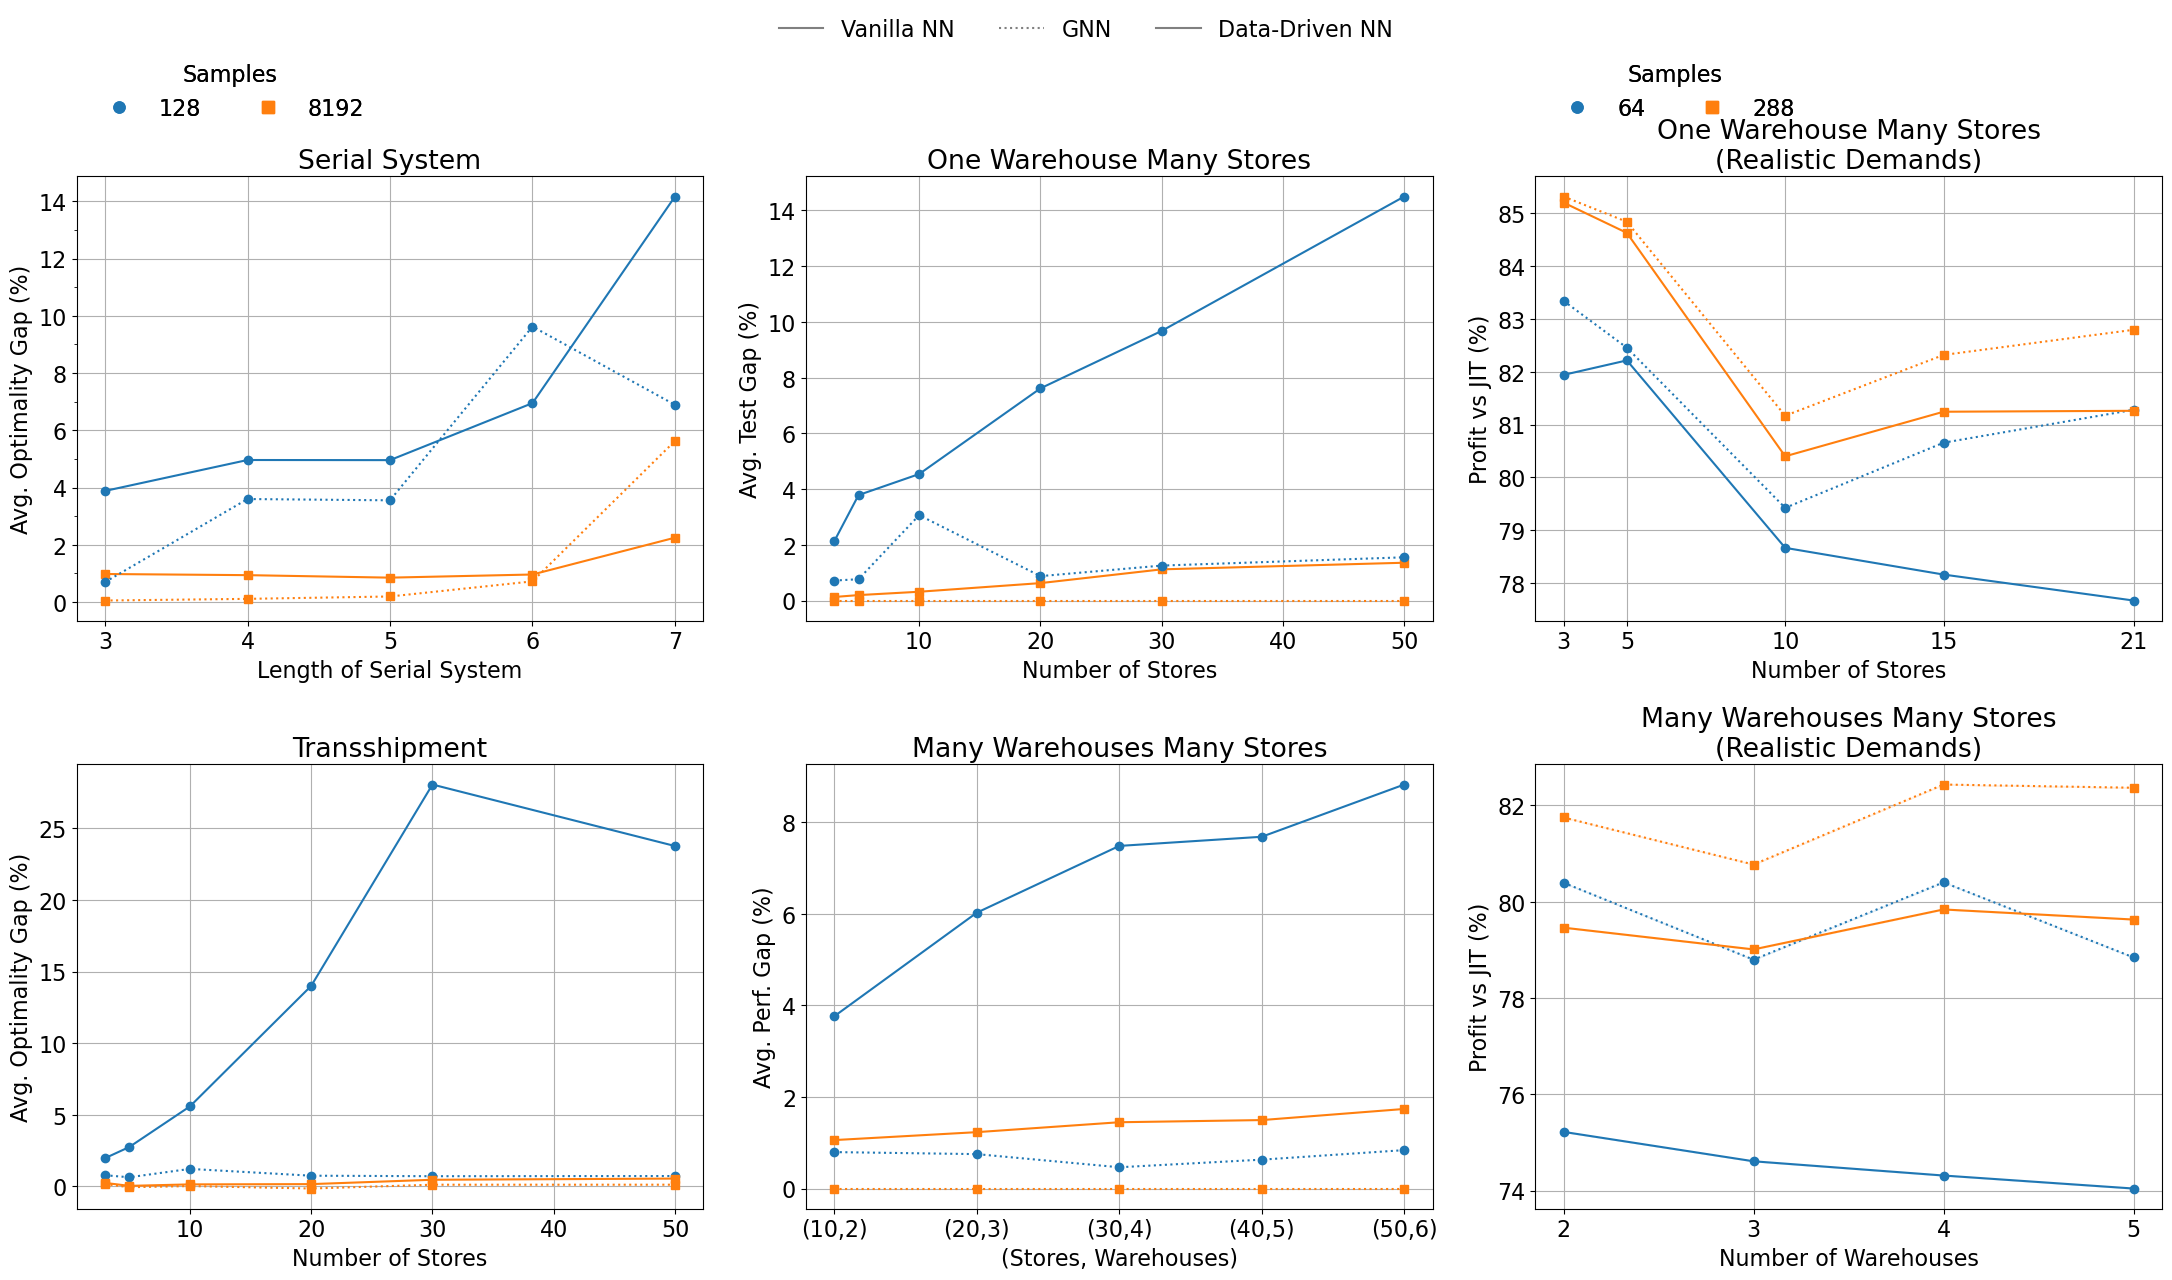

In [58]:

# --- Plot Functions ---

EXCLUDED_SAMPLE_SIZE = 1024

def plot_serial_system(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    for (arch, sample_size), stats_list in stats.items():
        if sample_size == EXCLUDED_SAMPLE_SIZE:
            continue
        stats_df = pd.DataFrame(stats_list)
        if not stats_df.empty:
            system_length_array = stats_df['system_length'].to_numpy()
            mean_gap_array = stats_df['mean_gap'].to_numpy()
            ax.plot(system_length_array, mean_gap_array,
                    marker=marker_scheme[sample_size],
                    color=color_scheme[sample_size],
                    linestyle=linestyle_scheme.get(arch, "-"),
                    markersize=6)
    ax.set_xlabel('Length of Serial System')
    ax.set_ylabel('Avg. Optimality Gap (%)')
    ax.set_title('Serial System')
    ax.grid(True)
    ax.set_xticks(range(3, 8))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    return linestyle_scheme, color_scheme, marker_scheme

def plot_one_warehouse(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    for (arch, sample_size), stats_list in stats.items():
        if sample_size == EXCLUDED_SAMPLE_SIZE:
            continue
        stats_df = pd.DataFrame(stats_list)
        if not stats_df.empty:
            n_stores_array = stats_df['n_stores'].to_numpy()
            mean_gap_array = stats_df['mean_gap'].to_numpy()
            ax.plot(n_stores_array, mean_gap_array,
                    marker=marker_scheme[sample_size],
                    color=color_scheme[sample_size],
                    linestyle=linestyle_scheme.get(arch, "-"),
                    markersize=6)
    ax.set_xlabel('Number of Stores')
    ax.set_ylabel('Avg. Test Gap (%)')
    ax.set_title('One Warehouse Many Stores')
    ax.grid(True)
    return linestyle_scheme, color_scheme, marker_scheme

def plot_transshipment(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    for (arch, sample_size), stats_list in stats.items():
        if sample_size == EXCLUDED_SAMPLE_SIZE:
            continue
        stats_df = pd.DataFrame(stats_list)
        if not stats_df.empty:
            n_stores_array = stats_df['n_stores'].to_numpy()
            mean_gap_array = stats_df['mean_gap'].to_numpy()
            ax.plot(n_stores_array, mean_gap_array,
                    marker=marker_scheme[sample_size],
                    color=color_scheme[sample_size],
                    linestyle=linestyle_scheme.get(arch, "-"),
                    markersize=6)
    ax.set_xlabel('Number of Stores')
    ax.set_ylabel('Avg. Optimality Gap (%)')
    ax.set_title('Transshipment')
    ax.grid(True)
    return linestyle_scheme, color_scheme, marker_scheme

def plot_real_one_warehouse(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    store_counts = data["store_counts"]
    for (arch, sample_size), stats_list in stats.items():
        if sample_size == EXCLUDED_SAMPLE_SIZE:
            continue
        stats_df = pd.DataFrame(stats_list)
        if not stats_df.empty:
            stats_df = stats_df.sort_values('n_stores')
            n_stores_array = stats_df['n_stores'].to_numpy()
            mean_percentage_array = stats_df['mean_percentage'].to_numpy()
            ax.plot(n_stores_array, mean_percentage_array,
                    marker=marker_scheme[sample_size],
                    color=color_scheme[sample_size],
                    linestyle=linestyle_scheme.get(arch, "-"),
                    markersize=6)
    ax.set_xlabel('Number of Stores')
    ax.set_ylabel('Profit vs JIT (%)')
    ax.set_title('One Warehouse Many Stores\n(Realistic Demands)')
    ax.grid(True)
    ax.set_xticks(store_counts)
    return linestyle_scheme, color_scheme, marker_scheme

def plot_many_warehouses(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    x_ticks = data["x_ticks"]
    x_tick_labels = data["x_tick_labels"]
    for (arch, sample_size), stats_list in stats.items():
        if sample_size == EXCLUDED_SAMPLE_SIZE:
            continue
        stats_df = pd.DataFrame(stats_list)
        if not stats_df.empty:
            stats_df = stats_df.sort_values('n_stores')
            n_stores_array = stats_df['n_stores'].to_numpy()
            mean_gap_array = stats_df['mean_gap'].to_numpy()
            ax.plot(n_stores_array, mean_gap_array,
                    marker=marker_scheme[sample_size],
                    color=color_scheme[sample_size],
                    linestyle=linestyle_scheme.get(arch, "-"),
                    markersize=6)
    ax.set_xlabel('(Stores, Warehouses)')
    ax.set_ylabel('Avg. Perf. Gap (%)')
    ax.set_title('Many Warehouses Many Stores')
    ax.grid(True)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)
    return linestyle_scheme, color_scheme, marker_scheme

def plot_real_many_warehouses(ax, data):
    stats = data["stats"]
    linestyle_scheme = data["linestyle_scheme"]
    color_scheme = data["color_scheme"]
    marker_scheme = data["marker_scheme"]
    x_ticks = data["x_ticks"]
    for (arch, sample_size), stats_list in stats.items():
        if sample_size == EXCLUDED_SAMPLE_SIZE:
            continue
        stats_df = pd.DataFrame(stats_list)
        if not stats_df.empty:
            stats_df = stats_df.sort_values('n_warehouses')
            n_warehouses_array = stats_df['n_warehouses'].to_numpy()
            mean_percentage_array = stats_df['mean_percentage'].to_numpy()
            ci_lower_array = stats_df['ci_lower'].to_numpy()
            ci_upper_array = stats_df['ci_upper'].to_numpy()
            ax.plot(n_warehouses_array, mean_percentage_array,
                    marker=marker_scheme[sample_size],
                    color=color_scheme[sample_size],
                    linestyle=linestyle_scheme.get(arch, "-"),
                    markersize=6)
            ax.fill_between(n_warehouses_array,
                            ci_lower_array,
                            ci_upper_array,
                            color=color_scheme[sample_size],
                            alpha=0.1)
    ax.set_xlabel('Number of Warehouses')
    ax.set_ylabel('Profit vs JIT (%)')
    ax.set_title('Many Warehouses Many Stores\n(Realistic Demands)')
    ax.grid(True)
    ax.set_xticks(x_ticks)
    return linestyle_scheme, color_scheme, marker_scheme

# --- Plotting Section ---
fig, axes = plt.subplots(2, 3, figsize=(22, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.35)

legend_schemes = []
legend_schemes.append(plot_serial_system(axes[0, 0], serial_system_data))
legend_schemes.append(plot_one_warehouse(axes[0, 1], one_warehouse_data))
legend_schemes.append(plot_real_one_warehouse(axes[0, 2], real_one_warehouse_data))
legend_schemes.append(plot_transshipment(axes[1, 0], transshipment_data))
legend_schemes.append(plot_many_warehouses(axes[1, 1], many_warehouses_data))
legend_schemes.append(plot_real_many_warehouses(axes[1, 2], real_many_warehouses_data))

# Get legend handles for synthetic (left) and real (right) separately
linestyle_scheme_syn, color_scheme_syn, marker_scheme_syn = legend_schemes[0]
arch_lines_syn, sample_patches_syn = make_legends(linestyle_scheme_syn, color_scheme_syn, marker_scheme_syn)

linestyle_scheme_real, color_scheme_real, marker_scheme_real = legend_schemes[2]
arch_lines_real, sample_patches_real = make_legends(linestyle_scheme_real, color_scheme_real, marker_scheme_real)

# Combine all unique policy handles for a single legend box at the top
all_arch_lines = []
seen_labels = set()
for arch_lines in [arch_lines_syn, arch_lines_real]:
    for line in arch_lines:
        if line.get_label() not in seen_labels:
            all_arch_lines.append(line)
            seen_labels.add(line.get_label())

# Place the single policy legend box at the top center
policy_legend = fig.legend(
    handles=all_arch_lines,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.08),
    fontsize=FONTSIZE,
    ncol=len(all_arch_lines),
    frameon=False
)
legend_y_offset = 1.3

syn_sample_sizes = [8192, 128]
real_sample_sizes = [288, 64]

sample_legend_syn_handles = [patch for patch in sample_patches_syn if int(patch.get_label()) in syn_sample_sizes]
sample_legend_syn = axes[0, 0].legend(
    handles=sample_legend_syn_handles,
    title='Samples',
    loc='upper left',
    bbox_to_anchor=(0, legend_y_offset),
    fontsize=FONTSIZE,
    ncol=len(sample_legend_syn_handles),
    frameon=False
)
axes[0, 0].add_artist(sample_legend_syn)
sample_legend_syn.get_title().set_fontsize(FONTSIZE)

sample_legend_real_handles = [patch for patch in sample_patches_real if int(patch.get_label()) in real_sample_sizes]
sample_legend_real = axes[0, 2].legend(
    handles=sample_legend_real_handles,
    title='Samples',
    loc='upper left',
    bbox_to_anchor=(0, legend_y_offset),
    fontsize=FONTSIZE,
    ncol=len(sample_legend_real_handles),
    frameon=False
)
axes[0, 2].add_artist(sample_legend_real)
sample_legend_real.get_title().set_fontsize(FONTSIZE)

plt.tight_layout()
plt.show()